# Objective- Apply SVM on amazon fine food review for featurization TFIDF

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

## Loading the data

In [60]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [61]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sql_data=sqlite3.connect('database.sqlite')
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql_data)

In [5]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
# converting five score value to two vlaue- 0 for negative and 1 for positive
def pos_neg(x):
    if x<=3:
        return 0
    else:
        return 1
data['Score']=data['Score'].map(pos_neg)

In [7]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning

In [8]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']]
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)  #dropping the duplicates in the datasets

In [9]:
data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [15]:
#sampling the data
sample_data=data.sort_values(['Time'])#time based sorting 
sample_data=sample_data.iloc[:50000] #taking 50k datapoints
sample_score=sample_data['Score']

In [16]:
import nltk
from nltk.corpus import stopwords
import re

stop=set(stopwords.words('english'))   #stopwords of english language
sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [17]:
#filtering sentence
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [18]:
sample_data['Cleaned_text']=final_string  #adding a new column in sample_data

In [19]:
sample_data.to_csv('sample_svm.csv')# saving this file to use the same set of sample datapoints for all featurization

In [62]:
sample_data=pd.read_csv('sample_svm.csv')

In [63]:
#taking the test data seperate from all other
from sklearn.model_selection import train_test_split
X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3, shuffle=False) #splitting the data

In [64]:
# this function predicting accuracy, confusion matrix and classification report

def svm_plot(clf, x_train, y_train, x_test, y_test):
          
    #predicting y and accuracy
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_pred,y_test)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
    
    
    return accu, TNR, TPR, FPR, FNR

#  SVC for Tfidf

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [66]:
from sklearn.preprocessing import normalize
x_train_tfidf=normalize(x_train_tfidf)
x_test_tfidf=normalize(x_test_tfidf)

## Applying GridSearchCV on SVC 

In [ ]:
from sklearn.svm import SVC

tscv=TimeSeriesSplit(n_splits=10)
gamma=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'gamma':gamma}
clf=SVC()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=-1, verbose=1)

In [ ]:
# fitting the model
clf.fit(x_train_tfidf,y_train)


In [40]:
import pickle
pickle.dump(clf,open('svm_tfidf_grid.p','wb'))

In [42]:
# best value of C
c=clf.best_estimator_.get_params()['C']
gamma=clf.best_estimator_.get_params()['gamma']
print('best C=',c)
print('best penalty=',gamma)

best C= 150
best penalty= 0.005


accuracy= 91.53999999999999
**********************************************************************

confusion matrix--


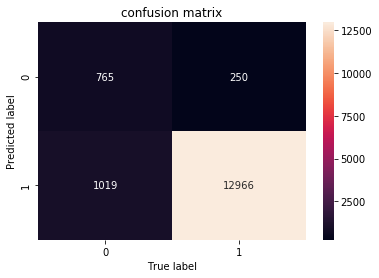

**********************************************************************

TNR= 0.4288116591928251
TPR= 0.9810835351089588
FPR= 0.5711883408071748
FNR= 0.018916464891041162
**********************************************************************

             precision    recall  f1-score   support

          0       0.43      0.75      0.55      1015
          1       0.98      0.93      0.95     13985

avg / total       0.94      0.92      0.93     15000

**********************************************************************



In [51]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

## Applying RandomizedSearchCV on SVC

In [79]:
from sklearn.model_selection import RandomizedSearchCV

tscv=TimeSeriesSplit(n_splits=10)
gamma=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200], 'gamma':gamma}
clf=SVC()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param,cv=tscv, n_jobs=-1)

In [80]:
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
end=datetime.now()
print('duration=',(end-start))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
duration= 0:37:58.031814


In [81]:
# best value of C
c=clf.best_estimator_.get_params()['C']
gamma=clf.best_estimator_.get_params()['gamma']
print('best C=',c)
print('best penalty=',gamma)

best C= 150
best penalty= 0.5


accuracy= 91.75999999999999
**********************************************************************

confusion matrix--


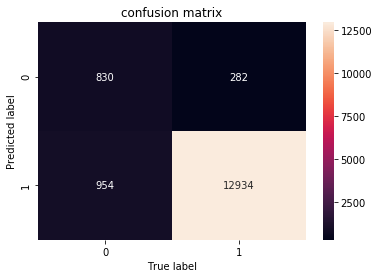

**********************************************************************

TNR= 0.46524663677130046
TPR= 0.9786622276029056
FPR= 0.5347533632286996
FNR= 0.02133777239709443
**********************************************************************

             precision    recall  f1-score   support

          0       0.47      0.75      0.57      1112
          1       0.98      0.93      0.95     13888

avg / total       0.94      0.92      0.93     15000

**********************************************************************



In [82]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

In [83]:
import pickle
pickle.dump(clf,open('svm_tfidf_random.p','wb'))

## Applying GridSearchCV on SGDClassifier with loss function= hinge

In [73]:
from sklearn.linear_model import SGDClassifier

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l1', 'l2']
param={'alpha': [0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'penalty':penalty}
clf=SGDClassifier()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [74]:
%time
start=datetime.now()
clf.fit(x_train_tfidf,y_train)
end=datetime.now()
print('duration=',(end-start))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits
duration= 0:00:10.885848


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.8s finished


In [75]:
# best value of C
penalty=clf.best_estimator_.get_params()['penalty']
alpha=clf.best_estimator_.get_params()['alpha']
print('best alpha=',alpha)
print('best penalty=',penalty)

best alpha= 5e-05
best penalty= l2


accuracy= 91.17333333333333
**********************************************************************

confusion matrix--


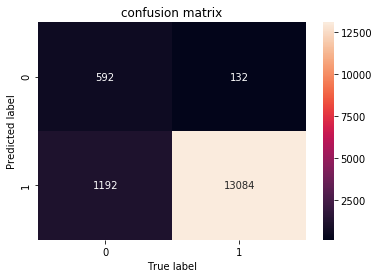

**********************************************************************

TNR= 0.33183856502242154
TPR= 0.9900121065375302
FPR= 0.6681614349775785
FNR= 0.009987893462469734
**********************************************************************

             precision    recall  f1-score   support

          0       0.33      0.82      0.47       724
          1       0.99      0.92      0.95     14276

avg / total       0.96      0.91      0.93     15000

**********************************************************************



In [76]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=x_train_tfidf, y_train=y_train, x_test=x_test_tfidf, y_test=y_test)

# Performance Table

| sno | featurization | model algo | cv algo | best C | best gamma | accuracy | TNR | TPR | f1-score |
|-----|---------------|---------------|--------------------|-------------|------------|----------|--------|--------|----------|
| 1 | Tfidf | SVC | GridSearchCV | 150 | 0.005 | 91.5399 | 0.4288 | 0.9810 | 0.93 |
| 2 | Tfidf | SVC | RandomizedSearchCV | 150 | 0.5 | 91.7599 | 0.4652 | 0.9786 | 0.93 |


| sno | featurization | model algo | cv algo | best alpha | best penalty | accuracy | TNR | TPR | f1-score |
|-----|---------------|---------------|--------------|------------|--------------|----------|--------|--------|----------|
| 1 | Tfidf | SGDClassifier | GridSearchCV | 5e-05 | l2 | 91.1733 | 0.3318 | 0.9900 | 0.93 |

## Observation-
* SVC and SGDClassifier have same accuracy and f1 score but difference in TNR slightly